# import lib
这里导入一些库

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers.core import Dense,Activation
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,PReLU
from keras.models import Sequential,Model
from keras import backend as K
from keras.regularizers import l2
import os.path
import csv
import cv2
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import json
from keras import callbacks
seed = 42
%matplotlib inline

# Data exploration
主要看一下图片数据以及一些驾驶数据

In [3]:
data_path = '../../data_collected/'
# 打开CSV文件，这里可以用csv库，或者pandas库
with open(data_path+'driving_log.csv','r') as csvfile:
    file_reader = csv.reader(csvfile,delimiter=',')
    log = []
    for row in file_reader:
        log.append(row)
log = np.array(log)
log = log[1:,:] #remove the header
# 打印出log文件中有多少张图片以及转角数据
print('DataSet: \n {} images| Numbers of steering data:{}'.format(len(log)*3,len(log)))
# 验证数量是否匹配
ls_imgs = glob.glob(data_path+'IMG/*.jpg')
#assert len(ls_imgs)==len(log)*3 #这里我们发现实际图片比log中记录的图片多出了三张
len(ls_imgs)

DataSet: 
 22362 images| Numbers of steering data:7454


22365

# Image Visualization
这里我们将图片显示出来并，配上对应的转角

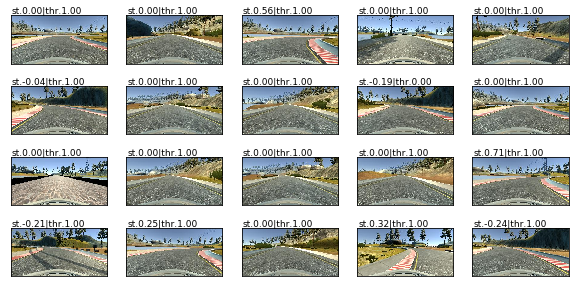

In [4]:
# 随机选择20张图片
n_imgs =20
steering_col = 3
throttle_col = 4
ls_imgs = np.random.choice(np.arange(len(log)),size=n_imgs,replace = False)

_,ax = plt.subplots(4,5,figsize=(10,5))
col,row = 0,0
for i in ls_imgs:
    img = cv2.imread(log[i,0])
    #print(data_path+log[i,0])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)#cv2.imread()默认读取图像的格式是BGR;numpy.imread()读取图像的格式是RGB
    ax[row,col].imshow(img)
    sub_title = 'st.{:.2f}|thr.{:.2f}'.format(float(log[i,steering_col]),float(log[i,throttle_col]))
    ax[row,col].text(3,-5,sub_title,fontsize=9)
    ax[row,col].get_xaxis().set_ticks([])
    ax[row,col].get_yaxis().set_ticks([])
    if col == 4:
        row,col = row+1,0
    else:
        col+=1
plt.show()

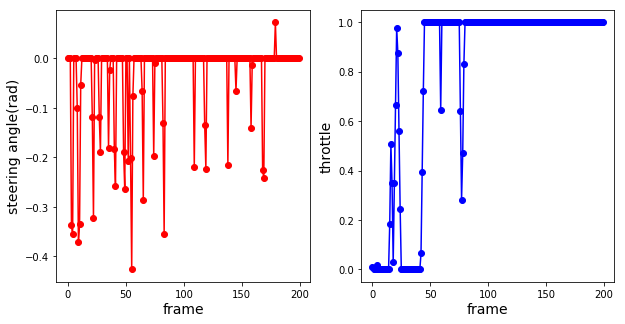

In [5]:
_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.arange(200),log[200:400,steering_col].astype(float),'r-o')
ax[0].set_xlabel('frame',fontsize=14)
ax[0].set_ylabel('steering angle(rad)',fontsize=14)

ax[1].plot(np.arange(200),log[200:400,throttle_col].astype(float),'b-o')
ax[1].set_xlabel('frame',fontsize=14)
ax[1].set_ylabel('throttle',fontsize=14)

plt.show()

# steering angle exploration

Number of unique angles value(precision = 0.0001):1508


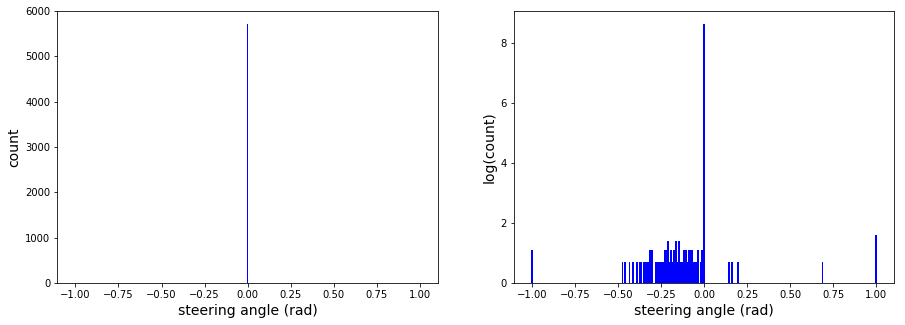

Count of positive angles:255|Negative angles:1482


In [6]:
# 设置转角值得精度为小数点后4位
precision = 0.0001
steering_angle = log[:,3].astype(float)*1/precision
steering_angle = steering_angle.astype(int)*precision

unique_st_angles = np.unique(steering_angle)
# 看一下转角的分布情况
print('Number of unique angles value(precision = 0.0001):{}'.format(len(unique_st_angles)))

# 画出转角的分布直方图
hist = []
for i in unique_st_angles:
    count = np.sum(steering_angle==i)
    hist.append([i,count])
hist = np.array(hist)

_,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(hist[:,0],hist[:,1],width=0.01,color='b')
ax[0].set_xlabel('steering angle (rad)',fontsize=14)
ax[0].set_ylabel('count',fontsize=14)

ax[1].bar(hist[:,0],np.log(hist[:,1]),width=0.01,color='b')
ax[1].set_xlabel('steering angle (rad)',fontsize=14)
ax[1].set_ylabel('log(count)',fontsize=14)

plt.show()

cnt_neg = np.sum(steering_angle<0)
cnt_pos = np.sum(steering_angle>0)
print('Count of positive angles:{}|Negative angles:{}'.format(cnt_pos,cnt_neg))

在分类问题中，我们常常需要去检查样本是否是均衡分布的。比如在上文中的样本中负角度的数量是正角度的7倍！模型就会有着极大地可能性去预测0值及负值。由于我一开始没考虑到这块，直接导致我使用模型进行自动驾驶时，车一开始便往左行驶。
因此我们准备直接使用官方提供的数据集进行进一步的分析。链接如下：[data_set](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

我们来重新探索下数据集，并看下数据的分布

DataSet: 
 24108 images| Numbers of steering data:8036


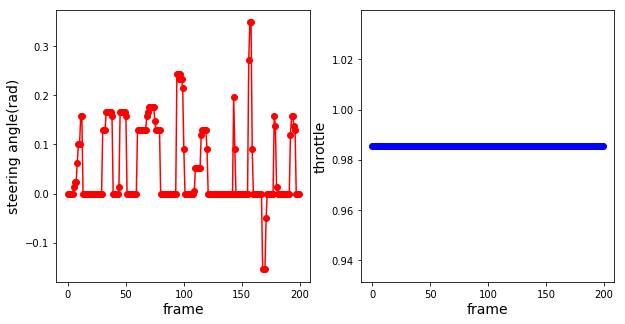

Number of unique angles value(precision = 0.0001):124


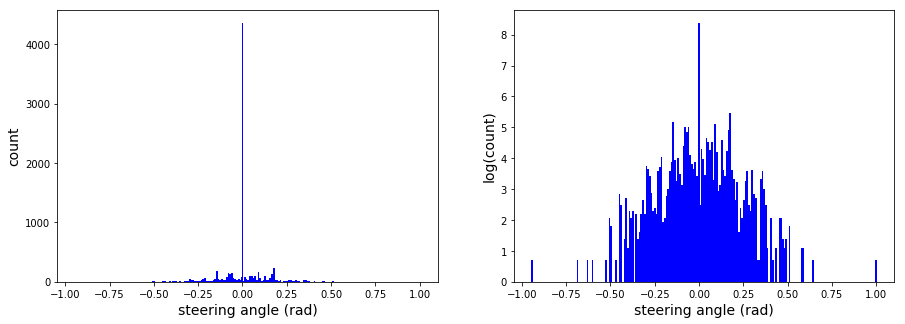

Count of positive angles:1900|Negative angles:1775


In [7]:
data_path = 'data/'
# 打开CSV文件，这里可以用csv库，或者pandas库
with open(data_path+'driving_log.csv','r') as csvfile:
    file_reader = csv.reader(csvfile,delimiter=',')
    log = []
    for row in file_reader:
        log.append(row)
log = np.array(log)
log = log[1:,:] #remove the header
# 打印出log文件中有多少张图片以及转角数据
print('DataSet: \n {} images| Numbers of steering data:{}'.format(len(log)*3,len(log)))
# 验证数量是否匹配
ls_imgs = glob.glob(data_path+'IMG/*.jpg')
assert len(ls_imgs)==len(log)*3 

_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.arange(200),log[200:400,steering_col].astype(float),'r-o')
ax[0].set_xlabel('frame',fontsize=14)
ax[0].set_ylabel('steering angle(rad)',fontsize=14)

ax[1].plot(np.arange(200),log[200:400,throttle_col].astype(float),'b-o')
ax[1].set_xlabel('frame',fontsize=14)
ax[1].set_ylabel('throttle',fontsize=14)

plt.show()
# 设置转角值得精度为小数点后4位
precision = 0.0001
steering_angle = log[:,3].astype(float)*1/precision
steering_angle = steering_angle.astype(int)*precision

unique_st_angles = np.unique(steering_angle)
# 看一下转角的分布情况
print('Number of unique angles value(precision = 0.0001):{}'.format(len(unique_st_angles)))

# 画出转角的分布直方图
hist = []
for i in unique_st_angles:
    count = np.sum(steering_angle==i)
    hist.append([i,count])
hist = np.array(hist)

_,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(hist[:,0],hist[:,1],width=0.01,color='b')
ax[0].set_xlabel('steering angle (rad)',fontsize=14)
ax[0].set_ylabel('count',fontsize=14)

ax[1].bar(hist[:,0],np.log(hist[:,1]),width=0.01,color='b')
ax[1].set_xlabel('steering angle (rad)',fontsize=14)
ax[1].set_ylabel('log(count)',fontsize=14)

plt.show()

cnt_neg = np.sum(steering_angle<0)
cnt_pos = np.sum(steering_angle>0)
print('Count of positive angles:{}|Negative angles:{}'.format(cnt_pos,cnt_neg))

很明显上图中，负角度与正角度的分布就比较均衡了

Number of unique throttle opening value:95


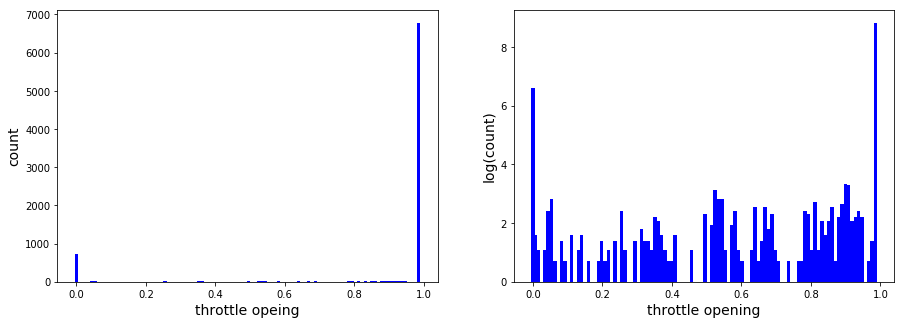

In [8]:
throttle = log[:,4].astype(float)

unique_throttle = np.unique(throttle)
print('Number of unique throttle opening value:{}'.format(len(unique_throttle)))

hist = []
for i in unique_throttle:
    count = np.sum(throttle==i)
    hist.append([i,count])

hist = np.array(hist)
_,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].bar(hist[:,0],hist[:,1],width=0.01,color='b')
ax[0].set_xlabel('throttle opeing',fontsize=14)
ax[0].set_ylabel('count',fontsize=14)

ax[1].bar(hist[:,0],np.log(hist[:,1]),width=0.01,color='b')
ax[1].set_xlabel('throttle opening',fontsize=14)
ax[1].set_ylabel('log(count)',fontsize=14)

plt.show()


# Data Preparation

## DataSplit
在对图像进行预处理之前，我们可以将数据集按照5：1的比例划分成训练集与验证集
## Region of Interest
在模型的使用中，我们希望模型能够专注于与驾驶相关的像素或特征上，例如，车道线。因此我们会将图像沿垂直方向进行裁剪，底部裁剪20px，顶部裁剪80px,并将图像resize到（128，128）

## Data augmentation
接下里我们将从亮度、水平翻转、cross-track error几个角度来进行数据增强

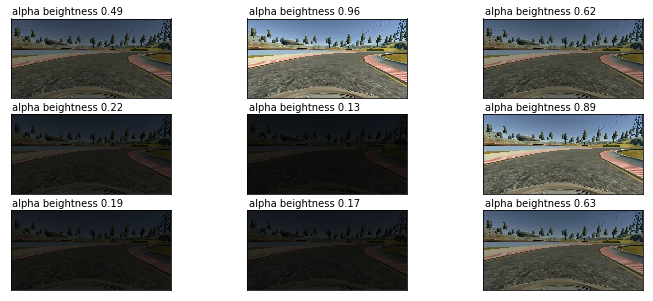

In [9]:
# Variation of brightness
#这里我们随机选取一张图片，生成9张不同brightness的图片,这里将亮度值调暗比例设置在0.1-1之间，值越小，图片亮度越暗
n_imgs = 1
ls_imgs = np.random.choice(np.arange(len(log)),size=n_imgs,replace=False)

_,ax = plt.subplots(3,3,figsize=(12,5))
col,row = 0,0
for i in range(9):
    img_adress = data_path + log[ls_imgs[0],0]
    img = cv2.imread(img_adress)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)#HSV又称作HSB，B指Brightness
    alpha = np.random.uniform(low=0.1,high=1.0,size=None)
    v = hsv[:,:,2]
    v = v*alpha
    hsv[:,:,2] = v.astype('uint8')
    rgb = cv2.cvtColor(hsv.astype('uint8'),cv2.COLOR_HSV2RGB)
    ax[row,col].imshow(rgb)
    title_ = 'alpha beightness {:.2f}'.format(alpha)
    ax[row,col].text(3,-8,title_,fontsize=10,color='black')
    ax[row,col].get_xaxis().set_ticks([])
    ax[row,col].get_yaxis().set_ticks([])
    if col==2:
        row,col = row+1,0
    else:
        col+=1
plt.show()

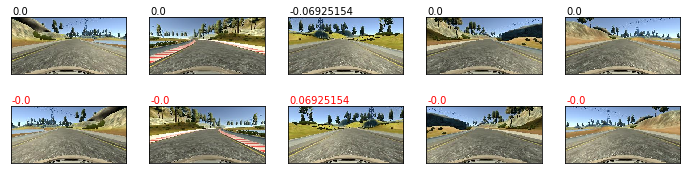

In [10]:
#水平翻转
#为了增大数据集，我们可以将图片水平翻转
n_imgs = 5
ls_imgs = np.random.choice(np.arange(len(log)),size=n_imgs,replace=False)

_,ax = plt.subplots(2,n_imgs,figsize=(12,3))
col,row = 0,0

for i in ls_imgs:
    img = cv2.imread(data_path+log[i,0])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[row,col].imshow(img)
    ax[row,col].text(3,-5,float(log[i,3]),fontsize=10,color='black')
    ax[row,col].get_xaxis().set_ticks([])
    ax[row,col].get_yaxis().set_ticks([])
    
    ax[row+1,col].imshow(cv2.flip(img,1))
    ax[row+1,col].text(3,-5,-float(log[i,3]),fontsize=10,color='red')
    ax[row+1,col].get_xaxis().set_ticks([])
    ax[row+1,col].get_yaxis().set_ticks([])
    
    col+=1
plt.show()

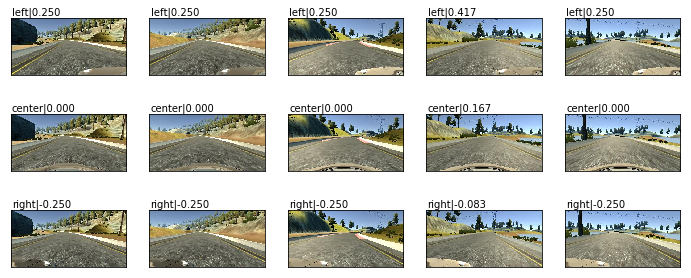

In [11]:
# cross-track error
# 从理论上讲，我们对左右摄像头之间的转角有一个粗略的估计，假如左摄像头与参考路径的夹角为S1,中间摄像头夹角为s2,右边摄像头的夹角为s3，
# 那么这些夹角之间存在这样的公式：s1 = s2+0.25;s3 = s2-0.25
def angle_viewpoint(st_angle,camera_side='center'):
    if camera_side == 'left':
        return st_angle+0.25
    if camera_side == 'right':
        return st_angle-0.25
    else:
        return st_angle

n_imgs = 5
ls_imgs = np.random.choice(np.arange(len(log)),size=n_imgs,replace=False)

_,ax = plt.subplots(3,n_imgs,figsize=(12,5))
col,row = 0,0
for i in ls_imgs:
    for k,viewpoint in enumerate(['left','center','right']):
        img_adress = data_path + log[i,0].replace('center',viewpoint)
        img = cv2.imread(img_adress)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax[row+k,col].imshow(img)
        new_angle = angle_viewpoint(float(log[i,3]),viewpoint)
        title_ = viewpoint + '|' + "{:.3f}".format(new_angle)
        ax[row+k,col].text(3,-8,title_,fontsize=10,color='black')
        ax[row+k,col].get_xaxis().set_ticks([])
        ax[row+k,col].get_yaxis().set_ticks([])
    col+=1
plt.show()

除了上述介绍的三种数据增强的方法，我们还可以对数据集做如下处理：
1.去除数据集中转角为0的图像数据
2.缩小像素值的范围，原先像素值的范围是0-255，现在我们可以将像素范围缩小到-0.5-0.5
接下来我们把上述介绍的一些数据增强的方法，封装成函数

In [12]:
def horizontal_flip(img,label):
    '''
    随机水平翻转图像，概率为0.5
    img:原始图像 in array type
    label: 原始图像的转角值
    '''
    choice = np.random.choice([0,1])
    if choice==1:
        img,label = cv2.flip(img,1),-label
    return (img,label)

def transf_brightness(img,label):
    '''
    将一张图片的亮度值调暗，比例为0.1-1之间的随机数
    img:原始图像 in array type
    label:原始图像的转角值
    '''
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    alpha = np.random.uniform(low=0.1,high=1.0,size=None)
    v = hsv[:,:,2]
    v = v*alpha
    hsv[:,:,2] = v.astype('uint8')
    rgb = cv2.cvtColor(hsv.astype('uint8'),cv2.COLOR_HSV2RGB)
    return (rgb,label)

def center_RightLeft_swap(img_adress,label,label_corr=0.25):
    '''
    这里我们规定汽车校准行驶距离为4m,中间摄像头距离左右摄像头的距离均为1m
    img_adress:physical location of the original image file
    label:steering angle value of original image
    label_corr:correction of the steering angle to applied.default value=1/4
    '''
    swap = np.random.choice(['L','R','C'])
    
    if swap=='L':
        img_adress = img_adress.replace('center','left')
        corrected_label = label + label_corr
        return (img_adress,corrected_label)
    elif swap=='R':
        img_adress = img_adress.replace('center','right')
        corrected_label = label - label_corr
        return (img_adress,corrected_label)
    else:
        return (img_adress,label)

def filter_zero_steering(label,del_rate):
    '''
    label: list of steering angle value in the original dataset
    del_rate:rate of deletion-del_rate=0.9 means delete 90% of example with steering angle=0
    '''
    steering_zero_idx = np.where(label==0)
    steering_zero_idx = steering_zero_idx[0]
    size_del = int(len(steering_zero_idx)*del_rate)
    
    return np.random.choice(steering_zero_idx,size=size_del,replace=False)

def image_transformation(img_adress,label,data_dir):
    #img swap
    img_adress , label = center_RightLeft_swap(img_adress,label)
    # Read img file
    img = cv2.imread(data_dir+img_adress)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img , label = transf_brightness(img,label)
    #flip image
    img , label = horizontal_flip(img,label)
    return (img,label)

# Modeling
接下来我们将实现一个神经网络模型。我们定义一张图片的输入为128*128*3，模型由4个卷积层及3个全连接层构成，具体结构如下所述：
>* 第一层卷积层过滤器的尺寸为5x5，深度为8，步长为1，不使用全0填充，所以这一层输出的尺寸为(124，124)深度为8.那么这一层共有参数5x5x3x8+8=608
>* 第二层池化层，采用过滤器的大小为2x2，步长为2，不使用全0填充，所以这一层输出的尺寸为(62，62)深度为8
>* 第三层卷积层过滤器的尺寸为5x5，深度为8，步长为1，不使用全0填充，所以这一层输出尺寸为(58,58)深度为8，那么这一层共有参数5x5x8x8+8=1608
>* 第四层池化层，采用过滤器的大小为2x2，步长为2，不使用全0填充，所以这一层输出的尺寸为(29,29)深度为8
>* 第五层卷积层过滤器的尺寸为4x4，深度为16，步长为1，不使用全0填充，所以这一层输出尺寸为(26,26)深度为16，那么这一层共有参数4x4x8x16+16=2064
>* 第六层池化层，，采用过滤器的大小为2x2，步长为2，不使用全0填充，所以这一层输出的尺寸为(13，13)深度为16
>* 第七层卷积层过滤器的尺寸为5x5，深度为16，步长为1，不是用全0填充，所以这一层输出尺寸为（9,9）深度为16，那么这一层共有参数5x5x16x16+16=6416
>* “展平层”，尺寸大小为1296
>* 第八层全连接层，神经元个数128，参数个数1296x128+128=166016
>* 第九层全连接层，神经元个数50，参数个数128x50+50=6450
>* 第十层全连接层，神经元个数10，参数个数50x10+10=510
>* 第十一层全连接层，神经元个数为1，参数个数是10x1+1=11

In [13]:
def continuousSteering(img_sz,activation_fn='relu',l2_reg=[10**-3,10**-3]):
    pool_size = (2,2)
    model = Sequential()
    model.add(Conv2D(filters=8,kernel_size=(5,5),strides=(1,1),padding='valid',name='conv1',input_shape=img_sz,kernel_regularizer=l2(l2_reg[1])))
    
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size,padding='valid'))
    
    model.add(Conv2D(filters=8,kernel_size=(5,5),strides=(1,1),padding='valid',kernel_regularizer=l2(l2_reg[1])))
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size,padding='valid'))
    
    model.add(Conv2D(filters=8,kernel_size=(5,5),strides=(1,1),padding='valid',kernel_regularizer=l2(l2_reg[1])))
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size,padding='valid'))
    
    model.add(Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),padding='valid',kernel_regularizer=l2(l2_reg[1])))
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size,padding='valid'))
    
    model.add(Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding='valid',kernel_regularizer=l2(l2_reg[1])))
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(128,kernel_regularizer=l2(l2_reg[0])))
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    
    model.add(Dense(50,kernel_regularizer=l2(l2_reg[0])))
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    
    model.add(Dense(10,kernel_regularizer=l2(l2_reg[0])))
    if activation_fn=='elu':
        model.add(Activation('elu'))
    elif activation_fn=='prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    model.add(Dense(1,activation='linear',kernel_regularizer=l2(l2_reg[0]),kernel_initializer='he_normal'))
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam,loss='mean_squared_error')
    print('LightWeight Model is created and compiled..-activation:{}'.format(activation_fn))
    return model

In [23]:
def batch_generator(x,y,batch_size,img_sz,training=True,del_rate=0.95,data_dir='data/',monitor=True,yieldXY=True):
    '''
    生成训练batch：利用yield关键词修饰
    数据增强机制：水平翻转、改变亮度、改变视角
    在每一轮训练中，在使用数据增强前，先删除95%的转角为0的数据。
    x:被用作训练的所有图像的地址
    y:转角
    training:如果为True,生成数据增强后的训练集；如果为false，生成验证集
    batch_size:
    img_sz:生成的图像大小（height,width,channel）
    del_rate:需要删除转角为0的样本比例
    data_dir:图片的地址目录
    monitor:是否将特征与标签进行存储
    yieldXY:如果为真，yields (x,y),否则只yields x
    '''
    if training:
        y_bag = []
        x,y = shuffle(x,y)
        rand_zero_idx = filter_zero_steering(y,del_rate)
        new_x = np.delete(x,rand_zero_idx,axis=0)
        new_y = np.delete(y,rand_zero_idx,axis=0)
    else:
        new_x = x
        new_y = y
    offset = 0
    while True:
        X = np.empty((batch_size,*img_sz))
        Y = np.empty((batch_size,1))
        #generate a batch
        for example in range(batch_size):
            img_adress,img_steering = new_x[example+offset],new_y[example+offset]
            assert os.path.exists(data_dir+img_adress),'Image file['+img_adress+'] not found-'
            
            if training:
                img, img_steering = image_transformation(img_adress,img_steering,data_dir)
            else:
                img = cv2.imread(data_dir+img_adress)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            #crop、resize、scale
            X[example,:,:,:] = cv2.resize(img[80:140,0:320],(img_sz[0],img_sz[1]))/255.0-0.5
            Y[example] = img_steering
            if training:
                y_bag.append(img_steering)
            '''
            如果到达原始数据集末尾，就从头开始循环
            '''
            if (example+1)+offset > len(new_y)-1:
                x , y = shuffle(x,y)
                rand_zero_idx = filter_zero_steering(y,del_rate=del_rate)
                new_x = x
                new_y = y
                new_x = np.delete(new_x,rand_zero_idx,axis=0)
                new_y = np.delete(new_y,rand_zero_idx,axis=0)
                offset = 0
        if yieldXY:
            yield (X,Y)
        else:
            yield X
        offset = offset+batch_size
        if training:
            np.save('y_bag.npy',np.array(y_bag))
            np.save('Xbatch_sample.npy',X)#这里保存的是最后一个batch的images

In [24]:
#这里设置一些参数
test_size = 0.2
img_sz = (128,128,3)
batch_size = 200
data_agumentation = 200
nb_epoch = 15
del_rate = 0.95
activation_fn = 'relu'
l2_reg = [0.00001,0]
print('Total number of samples per EPOCH:{}'.format(batch_size*data_agumentation))

x_ = log[:,0]
y_ = log[:,3].astype(float)
x_,y_ = shuffle(x_,y_)
X_train,X_val,y_train,y_val = train_test_split(x_,y_,test_size=test_size,random_state=seed)
print('Train set size:{}|Validation set size:{}'.format(len(X_train),len(X_val)))

sample_per_epoch = batch_size*data_agumentation
#这里我们确保验证集大小为batch_size的倍数
nb_val_samples = len(y_val) - len(y_val)%batch_size

Total number of samples per EPOCH:40000
Train set size:6428|Validation set size:1608


In [25]:
#train model
model = continuousSteering(img_sz,activation_fn = activation_fn,l2_reg=l2_reg)
print(model.summary())
'''
Callbacks:给予验证集损失保存最佳训练轮数
1.如果验证损失降低了，保存模型或者2.当验证损失连续5次epoch不再改善就停止训练并保存模型
'''

model_path = os.path.expanduser('model.h5')
save_best = callbacks.ModelCheckpoint(model_path,monitor='val_loss',verbose=1,save_best_only=True,mode='min')#Save the model after every epoch.
early_stop = callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=15,verbose=0,mode='auto')
callbacks_list = [early_stop,save_best]

# batch generator default value:
history = model.fit_generator(batch_generator(X_train,y_train,batch_size,img_sz,training=True,del_rate=del_rate),
                              steps_per_epoch=200,
                             validation_steps= 80,
                             validation_data = batch_generator(X_val,y_val,batch_size,img_sz,training=False,monitor=False),
                             epochs = nb_epoch,verbose=1,callbacks=callbacks_list)
with open('model.json','w') as f:
    f.write(model.to_json())
model.save('model_.h5')
print('Model saved!')

LightWeight Model is created and compiled..-activation:relu
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 124, 124, 8)       608       
_________________________________________________________________
activation_9 (Activation)    (None, 124, 124, 8)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 8)         1608      
_________________________________________________________________
activation_10 (Activation)   (None, 58, 58, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D

In [56]:
#from keras.models import load_model
model = load_model('model_.h5')
model.compile("adam", "mse")
model.load_weights('model_.h5')
#steering angle prediction
duration = 200
#select a random start frame
start_frame = np.random.choice(np.arange(0,len(log)-int(duration),1))
data4eval = log[start_frame:start_frame+duration,[0,3]]

steering_pred = []

for img_adress in data4eval[:,0]:
    img = cv2.imread('data/'+img_adress)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img[80:140,0:320]#crop image
    img = cv2.resize(img,(128,128))/255.0-0.5
    transformed_image_array = img[None,:,:,:]
    steering_angle = float(model.predict(transformed_image_array,batch_size=1))
    steering_pred.append(steering_angle)

In [90]:
type(data4eval[0,1])

numpy.str_

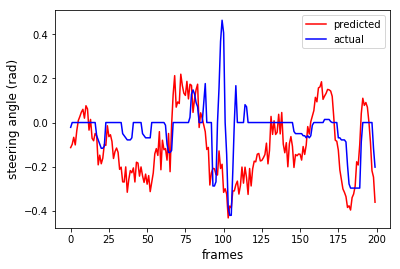

In [89]:
plt.plot(np.arange(0, int(duration), 1), steering_pred, color='red', label='predicted')
plt.plot(np.arange(0, int(duration), 1), data4eval[:,1].astype(float), color='blue', label='actual')#此处data4eval[:,1]的数据类型为numpy.str_必须进行格式转换
plt.xlabel('frames', fontsize=12)
plt.ylabel('steering angle (rad)', fontsize=12)
plt.legend()
plt.show()

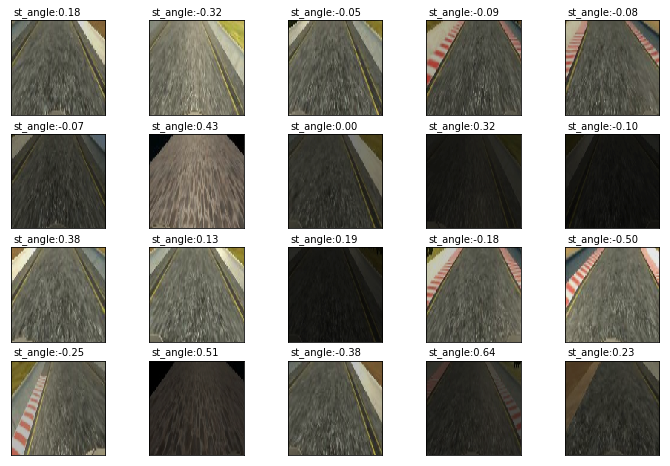

In [91]:
#下面我们对预处理后的图片进行可视化
img_check = np.load('Xbatch_sample.npy')
y_check = np.load('y_bag.npy')

n_imgs = 20
ls_imgs = np.random.choice(np.arange(len(img_check)),size=n_imgs,replace=False)

_,ax = plt.subplots(4,5,figsize=(12,8))
col,row = 0,0
for i in ls_imgs:
    img = (img_check[i,:,:,:]+0.5)*255#还原
    ax[row,col].imshow(img.astype('uint8'))
    title_ = 'st_angle:{:.2f}'.format(y_check[i])
    ax[row,col].text(3,-8,title_,fontsize=10,color='black')
    ax[row,col].get_xaxis().set_ticks([])
    ax[row,col].get_yaxis().set_ticks([])
    if col==4:
        row,col = row+1,0
    else:
        col+=1
plt.show()

Filters shape for the convolutional layers(format==[height,width,depth,nbr])
	 conv1:W(5, 5, 3, 8)
	 conv2:W(5, 5, 8, 8)
	 conv3:W(5, 5, 8, 8)
	 conv4:W(5, 5, 8, 16)


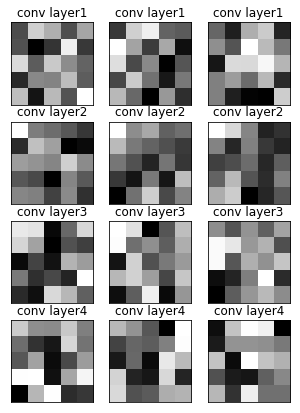

In [95]:
#可视化过滤器，这里我们选择特定层来可视化
_,ax = plt.subplots(4,3,figsize=(5,7))
col,row = 0,0
print('Filters shape for the convolutional layers(format==[height,width,depth,nbr])')
for layer_idx in [0,3,6,9]:
    weights = np.array(model.layers[laye r_idx].get_weights())[0]
    convlayer = int(layer_idx/3+1)
    print('\t conv{}:W{}'.format(convlayer,weights.shape))
    for kernel_idx in [0,1,2]:
        kernel = weights[:,:,0,kernel_idx]
        ax[row,col].imshow(kernel,cmap='gray',interpolation='none')
        ax[row,col].get_xaxis().set_ticks([])
        ax[row,col].get_yaxis().set_ticks([])
        
        ax[row,col].title.set_text('conv layer'+str(convlayer))
        col+=1
    row+=1
    col=0
plt.show()

# 可视化卷积层后的激活层
这里我们选取4张图片， 并将模型的4个卷积层后的激活层输出给显示出来

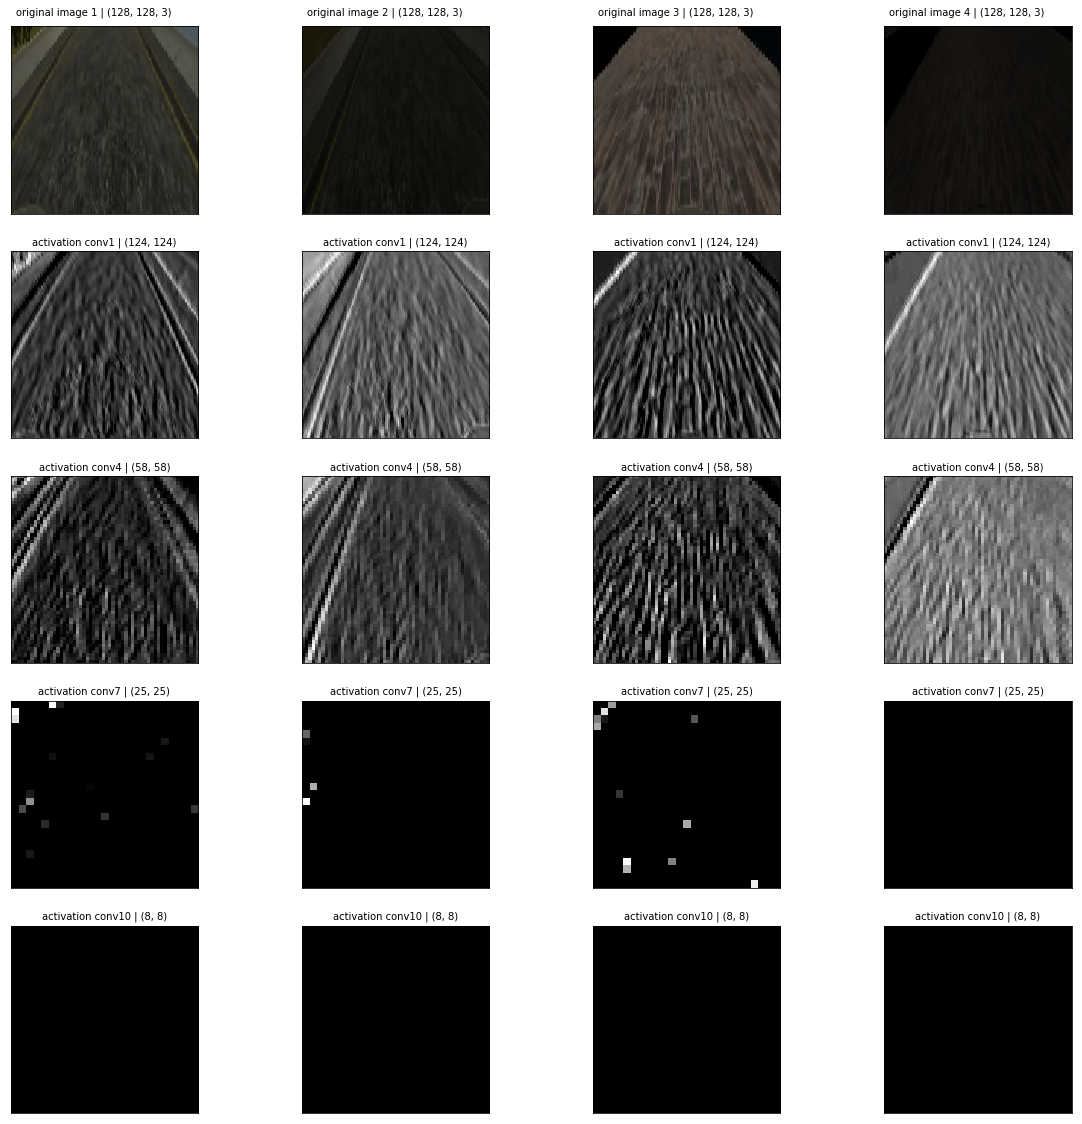

In [102]:
n_imgs = 4

ls_img = np.random.choice(np.arange(len(img_check)), size = n_imgs, replace=False)
_, ax = plt.subplots( 5, 4, figsize=(20,20) )

row, col = 0, 0

for k, img_id in enumerate(ls_img):
    img_input = img_check[img_id, :,:,:]
    img_input = img_input.reshape((1, *img_sz) )
    
    for layer_id in [-1, 1, 4, 7, 10]:
        
        if layer_id == -1: #show input image
            img_4display = (img_input[0] + 0.5) * 255 
            ax[row, col].ims
                        how(img_4display.astype('uint8'))
            how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
how(img_4display.astype('uint8'))
            title_ = 'original image {} | {}'.format(k + 1, img_4display.shape)
            ax[row, col].text(3, -8, title_, fontsize=10, color='black')
            ax[row, col].get_xaxis().set_ticks([])
            ax[row, col].get_yaxis().set_ticks([])
            row = row + 1

            
        else:
            get_layer_output = K.function([model.layers[0].input], [model.layers[layer_id].output])
            layer_output = get_layer_output([img_input])[0]
            title_ = 'activation conv{} | {}'.format(layer_id, layer_output[0, :,:,0].shape)
            ax[row, col].set_title(title_, fontsize=10, color='black')
            ax[row, col].imshow(layer_output[0,:,:,0], cmap='gray') #display 1st activation map
            ax[row, col].get_xaxis().set_ticks([])
            ax[row, col].get_yaxis().set_ticks([])
            if row == 4:
                row = 0
                col += 1
            else:
                row += 1